<a href="https://colab.research.google.com/github/SalwaMustafa/Image-Classification/blob/main/Copy_of_intel_image_classification_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
puneet6060_intel_image_classification_path = kagglehub.dataset_download('puneet6060/intel-image-classification')

print('Data source import complete.')


100%|██████████| 346M/346M [00:03<00:00, 113MB/s]

Extracting files...


Data source import complete.


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset , DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from torchvision import models
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_path = os.path.join(puneet6060_intel_image_classification_path, 'seg_train', 'seg_train')

In [ ]:
test_path = os.path.join(puneet6060_intel_image_classification_path, 'seg_test', 'seg_test')

In [ ]:
train_dirs = os.listdir(train_path)
print(len(train_dirs))
print(train_dirs)

6
['street', 'mountain', 'buildings', 'glacier', 'forest', 'sea']


In [ ]:
test_dirs = os.listdir(test_path)
print(len(test_dirs))
print(test_dirs)

6
['street', 'mountain', 'buildings', 'glacier', 'forest', 'sea']


In [ ]:
total_train_images = 0
train = []
for file_name in train_dirs:
    dir_path = train_path + '/' + file_name
    print(f'There are {len(os.listdir(dir_path))} images in {file_name} file')
    total_train_images += len(os.listdir(dir_path))

    for _ in os.listdir(dir_path):
        path = os.path.join(dir_path,_)
        train.append([path,file_name])

print(f"There are {total_train_images} train images ")
print(len(train))

There are 2382 images in street file
There are 2512 images in mountain file
There are 2191 images in buildings file
There are 2404 images in glacier file
There are 2271 images in forest file
There are 2274 images in sea file
There are 14034 train images 
14034


In [ ]:
total_test_images = 0
test = []
for file_name in test_dirs:

    dir_path = test_path + '/' + file_name
    print(f'There are {len(os.listdir(dir_path))} images in {file_name} file')
    total_test_images += len(os.listdir(dir_path))

    for _ in os.listdir(dir_path):
        path = os.path.join(dir_path,_)
        test.append([path,file_name])

print(f"There are {total_test_images} test images ")
print(len(test))

There are 501 images in street file
There are 525 images in mountain file
There are 437 images in buildings file
There are 553 images in glacier file
There are 474 images in forest file
There are 510 images in sea file
There are 3000 test images 
3000


mountain


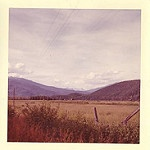

In [ ]:
img = Image.open(train[3000][0])
print(train[3000][1])
img

In [ ]:
random.seed(42)
random.shuffle(train)
random.shuffle(test)

In [ ]:
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:
train_transform = v2.Compose(
    [
        v2.Resize((299,299)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32 , scale = True),
        v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
test_transform = v2.Compose(
    [
        v2.Resize((299,299)),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32 , scale = True),
        v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

In [ ]:
class dataset(Dataset):
    def __init__(self , paths , transform = None ):

        self.paths = paths
        self.transform = transform

    def __getitem__(self,index):

        img = Image.open(self.paths[index][0])
        label = int(class_labels[self.paths[index][1]])

        if self.transform:
            img = self.transform(img)

        return img , label

    def __len__(self):
        return len(self.paths)

In [ ]:
train_data_tf = dataset(train , train_transform)
test_data_tf = dataset(test , test_transform )
train_loader_tf = DataLoader(train_data_tf , shuffle = True , batch_size = 32)
test_loader_tf = DataLoader(test_data_tf , shuffle = True , batch_size = 32)

In [ ]:
model_tf = models.inception_v3(weights = "IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 127MB/s] 


In [ ]:
model_tf.aux_logits = False
for parameter in model_tf.parameters():
    parameter.requires_grad = False

In [ ]:
num_of_calsses = 6
model_tf.fc = nn.Linear(model_tf.fc.in_features, num_of_calsses)

In [ ]:
for parameter in model_tf.fc.parameters():
    print(parameter.requires_grad)

True
True


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.005
best_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([p for p in model_tf.parameters() if p.requires_grad], lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
train_losses = []
test_losses = []
best_score = float("inf")

In [ ]:
model_tf.to(device)

In [ ]:
def train_epoch():
    epoch_loss = 0
    correct_predictions = 0
    total_samples = 0
    for i , (images , labels) in enumerate(train_loader_tf):

        images = images.to(device)
        labels = labels.to(device)

        #forward propagation
        out = model_tf(images)

        _ , predicted = torch.max(out.data ,  dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        loss = criterion(out , labels)
        epoch_loss += loss

        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return epoch_loss / len(train_loader_tf) , correct_predictions / total_samples

In [ ]:
def get_test_loss():

    epoch_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for i , (images , labels) in enumerate(test_loader_tf):

            images = images.to(device)
            labels = labels.to(device)

            #forward propagation
            out = model_tf(images)

            _ , predicted = torch.max(out.data ,  dim=1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            loss = criterion(out , labels)
            epoch_loss += loss

    return epoch_loss / len(test_loader_tf) , correct_predictions / total_samples

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
weights_path = '/content/drive/MyDrive/model_weights/inception_v3_weights.pth'

In [ ]:
num_epochs = 20

In [ ]:
for epoch in range(num_epochs):

    model_tf.train(True)
    avg_train_epoch_loss , avg_train_epoch_acc = train_epoch()

    model_tf.eval()
    avg_test_epoch_loss , avg_test_epoch_acc = get_test_loss()

    if(avg_test_epoch_loss < best_score):

        best_score = avg_test_epoch_loss
        best_acc = avg_test_epoch_acc
        torch.save(model_tf.state_dict(), weights_path)


    train_losses.append(avg_train_epoch_loss)
    test_losses.append(avg_test_epoch_loss)

    scheduler.step(avg_test_epoch_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"epoch : {epoch+1} --- Avg_Train_Loss = {avg_train_epoch_loss} --- Avg_Test_Loss = {avg_test_epoch_loss}")
    print(f"          --- Avg_Train_Acc = {avg_train_epoch_acc} --- Avg_Test_Acc = {avg_test_epoch_acc}")
    print(f"          --- Best Acc = {best_acc:.6f}")
    print(f"          --- Current Learning Rate = {current_lr:.6f}")
    print("="*100)

epoch : 1 --- Avg_Train_Loss = 0.611046552658081 --- Avg_Test_Loss = 0.34558141231536865
          --- Avg_Train_Acc = 0.784808322645005 --- Avg_Test_Acc = 0.871
          --- Best Acc = 0.871000
          --- Current Learning Rate = 0.005000
epoch : 2 --- Avg_Train_Loss = 0.6079246997833252 --- Avg_Test_Loss = 0.337643563747406
          --- Avg_Train_Acc = 0.8106740772409862 --- Avg_Test_Acc = 0.887
          --- Best Acc = 0.887000
          --- Current Learning Rate = 0.005000
epoch : 3 --- Avg_Train_Loss = 0.6511861085891724 --- Avg_Test_Loss = 0.3144219219684601
          --- Avg_Train_Acc = 0.811101610374804 --- Avg_Test_Acc = 0.8903333333333333
          --- Best Acc = 0.890333
          --- Current Learning Rate = 0.005000
epoch : 4 --- Avg_Train_Loss = 0.6404024362564087 --- Avg_Test_Loss = 0.3216417729854584
          --- Avg_Train_Acc = 0.8190822288727376 --- Avg_Test_Acc = 0.8926666666666667
          --- Best Acc = 0.890333
          --- Current Learning Rate = 0.005000
e